# Build a polymer/liquid mixture geometry using EMC.
Copyright ENEOS Corporation as contributors to Matlantis contrib project

Enhanced Monte Carlo\
https://montecarlo.sourceforge.net/emc/Welcome.html \
https://matsci.org/c/emc/50

P.J. in 't Veld and G.C. Rutledge, Macromolecules 2003, 36, 7358

In [1]:
import os
import sys
import numpy as np

from ase import Atoms, units
from ase.io import read, write, Trajectory
from ase.data import atomic_masses

from rdkit import Chem
from rdkit.Chem import AllChem, Draw


In [2]:
from pfcc_extras.visualize.view import view_ngl
from pfcc_extras.structure.ase_rdkit_converter import smiles_to_atoms, atoms_to_smiles

In [3]:
sys.path.insert(0, 'EMC_interface/src/emc_interface')
from emc_interface import EMCInterface

outputdir = './output'
os.makedirs(outputdir, exist_ok=True)

In [4]:
def set_elements_lammpsdata(atoms):
    mass_number = {int(np.round(m)):i for i, m in enumerate(atomic_masses)}
    masses = atoms.get_masses()
    numbers = [mass_number[int(np.round(m))] for m in masses] 
    atoms.numbers=numbers
    return atoms

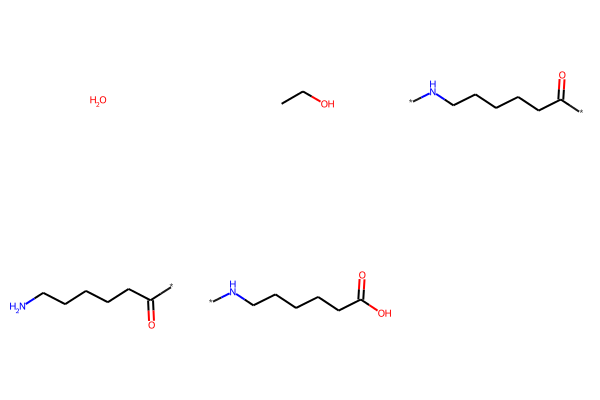

In [5]:
name_smiles_fractions = {"water":("O", 1), 
"alcohol":("CCO", 1),
# "salt":("[Na+].[Cl-]", 5)
}
smileses = [s for n,(s,f) in name_smiles_fractions.items()]

smiles_center = '*NCCCCCC(=O)*'
smiles_left = 'NCCCCCC(=O)*'
smiles_right = '*NCCCCCC(=O)O'

smileses.extend([smiles_center, smiles_left, smiles_right])

mols = [Chem.MolFromSmiles(smiles) for smiles in smileses]
view = Draw.MolsToGridImage(mols)
display(view)

settings = dict(
            name_smiles_fractions = name_smiles_fractions,
            smiles_center = smiles_center,
            smiles_left = smiles_left,
            smiles_right = smiles_right,
            polymer_fraction=1,
            ntotal = 2000,  # Number of atoms in the cell.
            density = 0.85, # Set slightly small density [g/cm3].
            field='pcff',
            ring_depth = 9,  #'auto', The max ring size in the molecules.
            build_dir = './build',
            lammps_prefix = 'mixture',
            project='mixture',
            seed=12345,
            repeat_center=8,  # 10 monomers with center + left + right 
)

In [6]:
ntotal, settings['ntotal'] = settings['ntotal'], 400

builder = EMCInterface()
builder.verbose  =True
builder.setup('mixture', **settings)
builder.build()

basename =  f'{builder.settings["project"]}'
atoms = read(f'{basename}.pdb')
print(f'Number of atoms: {len(atoms)} (< {settings["ntotal"]})')
settings['ntotal'] = ntotal

view_ngl([atoms], ['ball+stick'], replace_structure=True)

{'center': '*NCCCCCC(=O)*', 'left': 'NCCCCCC(=O)*', 'right': '*NCCCCCC(=O)O', 'field': 'pcff', 'ntotal': 400, 'density': 0.85, 'ring_depth': 9, 'build_dir': './build', 'lammps_prefix': 'mixture', 'project': 'mixture', 'seed': 12345, 'emc_execute': 'false', 'polymer_fraction': 1, 'repeat_center': 8, 'repeat_left': 1, 'repeat_right': 1, 'groups': 'water           O\nalcohol         CCO', 'clusters': 'water           water,1\nalcohol         alcohol,1\npoly            alternate,1'}
EMC Setup v4.1.3 (April 7, 2022), (c) 2004-2022 Pieter J. in 't Veld

Info: reading script from "./setup.esh"
Info: phase1 = {water, alcohol, poly}
Info: project = mixture
Info: ntotal = 400
Info: direction = x
Info: shape = 1
Info: force field type = "cff"
Info: force field name = "EMC_interface/EMC/v9.4.4/field/pcff/pcff"
Info: force field location = "."
Info: build for LAMMPS script in "./build"
Info: creating EMC build script "build.emc"
Info: assuming mol fractions
Info: creating LAMMPS run script "mixture

In [7]:
builder = EMCInterface()
builder.setup('mixture', **settings)

In [8]:
builder.build()

In [9]:
savedir = os.path.join(outputdir, f'build_{builder.settings["project"]}')
print(savedir)
builder.savefiles(savedir)

./output/build_mixture


In [10]:
basename =  f'{savedir}/{builder.settings["project"]}'
atoms_lammpsdata = read(f'{basename}.data', format='lammps-data')
atoms_lammpsdata = set_elements_lammpsdata(atoms_lammpsdata)
atoms = read(f'{basename}.pdb')

view_ngl([atoms, atoms_lammpsdata], replace_structure=True)

In [11]:
import importlib
MODEL_VERSION='latest'
CALC_MODE='CRYSTAL_PLUS_D3'
def get_calculator(model_version=MODEL_VERSION, calc_mode=CALC_MODE):

    spec = importlib.util.find_spec('pfp_api_client')
    if spec is None:
        from ase.calculators.emt import EMT
        calculator = EMT()
        return calculator

    from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
    from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode 
    if isinstance(calc_mode, str):
        calc_mode = getattr(EstimatorCalcMode, calc_mode)
    estimator = Estimator(model_version=model_version, calc_mode=calc_mode)
    calculator = ASECalculator(estimator)
    return calculator 

In [12]:
from ase.optimize import BFGS
atoms.calc = get_calculator()
opt = BFGS(atoms)
opt.run(steps=5)

/home/jovyan/.local/lib/python3.7/site-packages/pfp_api_client/__init__.py:36: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  f"New version of {package_name} is available. Please consider"


      Step     Time          Energy         fmax
BFGS:    0 06:05:36    -8979.390676        6.6010
BFGS:    1 06:09:09    -9014.013712        5.7532
BFGS:    2 06:12:40    -9032.338436        1.9267
BFGS:    3 06:15:53    -9044.951392        3.0983
BFGS:    4 06:18:21    -9054.150727        3.6555
BFGS:    5 06:20:48    -9059.688634        2.4221
BFGS:    6 06:23:18    -9063.550021        1.1995
BFGS:    7 06:24:47    -9067.417495        1.6883
BFGS:    8 06:26:12    -9069.630417        2.1976
BFGS:    9 06:27:40    -9071.835789        1.1574
BFGS:   10 06:29:08    -9073.648670        1.2688


False

In [13]:
view_ngl(opt.atoms)